In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

Mounted at /content/gdrive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
with open('/content/gdrive/MyDrive/Colab Notebooks/advs.txt', encoding="utf8") as f:
    corpus = f.read().replace('\n',' ')

##Preprocessing

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

words = tokenizer.tokenize(corpus)

#Remove StopWords
table = str.maketrans('', '', string.punctuation)
words_stopwords_removed = [word.translate(table) for word in words]

#Remove Punctuations
stop_words = set(stopwords.words('english'))
words = [word for word in words_stopwords_removed if word not in stop_words and word != ""]

vocabulary = set(words)
word_to_index = {word: i for i, word in enumerate(vocabulary)}
index_to_word = {i: word for word, i in word_to_index.items()}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

##Updated Part 1

In [4]:
# UPDATE CODE - USING SKIPGRAM FUNCTION
from tensorflow.keras.preprocessing.sequence import skipgrams

sequence = [word_to_index[word] for word in words if word in word_to_index]


pair, labels = skipgrams(sequence, vocabulary_size=len(vocabulary), window_size=2, negative_samples=4.0)


In [7]:
import tensorflow as tf

#  hyperparameters
vocab_size = len(vocabulary)
embedding_dim = 300

# Model definition
input_target = tf.keras.Input(shape=(1,), dtype='int32')
input_context = tf.keras.Input(shape=(1,), dtype='int32')

initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05)
embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1, name='embedding_layer')

target_embedding = embedding_layer(input_target)
context_embedding = embedding_layer(input_context)

dot_product = tf.keras.layers.Dot(axes=-1)([target_embedding, context_embedding])
dot_product = tf.keras.layers.Reshape((1,))(dot_product)
output = tf.keras.layers.Activation('sigmoid')(dot_product)

model = tf.keras.Model(inputs=[input_target, input_context], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_layer (Embedding  (None, 1, 300)               2134800   ['input_3[0][0]',             
 )                                                                   'input_4[0][0]']             
                                                                                                  
 dot (Dot)                   (None, 1, 1)                 0         ['embedding_layer[0][0]', 

In [9]:
# Prepare inputs
import numpy as np
pairs_array = np.array(pair, dtype="int32")
labels_array = np.array(labels, dtype="int32")

target_words = pairs_array[:, 0]
context_words = pairs_array[:, 1]

In [22]:
# Train
model.fit([target_words, context_words], labels_array, epochs=30, batch_size=256, verbose=1)

Epoch 1/30
4015/4015 [==============================] - 126s 31ms/step - loss: 0.1471
Epoch 2/30
4015/4015 [==============================] - 122s 30ms/step - loss: 0.1140
Epoch 3/30
4015/4015 [==============================] - 124s 31ms/step - loss: 0.0947
Epoch 4/30
4015/4015 [==============================] - 125s 31ms/step - loss: 0.0835
Epoch 5/30
4015/4015 [==============================] - 128s 32ms/step - loss: 0.0769
Epoch 6/30
4015/4015 [==============================] - 125s 31ms/step - loss: 0.0730
Epoch 7/30
4015/4015 [==============================] - 123s 31ms/step - loss: 0.0705
Epoch 8/30
4015/4015 [==============================] - 123s 31ms/step - loss: 0.0688
Epoch 9/30
4015/4015 [==============================] - 121s 30ms/step - loss: 0.0674
Epoch 10/30
4015/4015 [==============================] - 124s 31ms/step - loss: 0.0665
Epoch 11/30
4015/4015 [==============================] - 119s 30ms/step - loss: 0.0658
Epoch 12/30
4015/4015 [=============================

In [23]:
word_vectors = model.get_layer('embedding_layer').get_weights()[0]

##Part2

In [28]:
def similarity(vec_a, vec_b):
    cosine_sim = np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
    return cosine_sim

king_vector = word_vectors[word_to_index.get('king')]
man_vector = word_vectors[word_to_index.get('man')]
woman_vector = word_vectors[word_to_index.get('woman')]

word1 = word_vectors[word_to_index.get('queen')]

word2 = king_vector - man_vector + woman_vector

similarity(word1, word2)

0.1430038

In [26]:
word1 = word_vectors[word_to_index.get('brother')]
word2 = word_vectors[word_to_index.get('sky')]

similarity(word1, word2)

-0.10515483

##Part3:

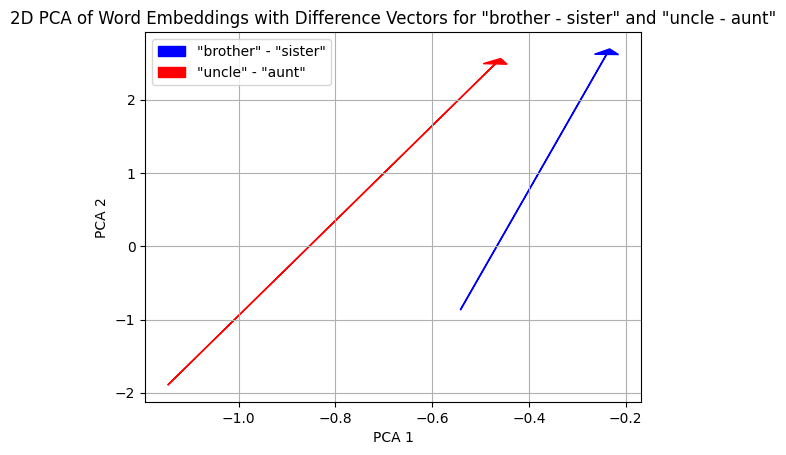

In [ ]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
word_vectors_reduced = pca.fit_transform(word_vectors)

import matplotlib.pyplot as plt
# "brother" - "sister" difference vector
brother_vec = word_vectors_reduced[word_to_index['brother']]
sister_vec = word_vectors_reduced[word_to_index['sister']]
diff_vec_brother_sister = brother_vec - sister_vec
plt.arrow(sister_vec[0], sister_vec[1], diff_vec_brother_sister[0], diff_vec_brother_sister[1],
          head_width=0.05, fc='blue', ec='blue', label='"brother" - "sister"')

# "uncle" - "aunt" difference vector
uncle_vec = word_vectors_reduced[word_to_index['uncle']]
aunt_vec = word_vectors_reduced[word_to_index['aunt']]
diff_vec_uncle_aunt = uncle_vec - aunt_vec
plt.arrow(aunt_vec[0], aunt_vec[1], diff_vec_uncle_aunt[0], diff_vec_uncle_aunt[1],
          head_width=0.05, fc='red', ec='red', label='"uncle" - "aunt"')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('2D PCA of Word Embeddings with Difference Vectors for "brother - sister" and "uncle - aunt"')
plt.legend()
plt.grid(True)
plt.show()